In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
env = gym.make('CartPole-v1')

/home/taohu88/miniconda3/envs/pymc/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:97: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  logger.warn(


In [3]:
env.observation_space.shape

(4,)

In [4]:
env.action_space

Discrete(2)

In [5]:
import numpy as np

def sigmoid(x):
    # definition of logistic function
    return 1/(1 + np.exp(-x))


def grad_log_p_v1(theta, x):
    # calculate grad-log-probs

    y = x @ theta
    grad_log_p0 = x - x * sigmoid(y)
    grad_log_p1 = - x * sigmoid(y)

    return grad_log_p0, grad_log_p1

In [19]:
import jax
import jax.numpy as jnp
import jax.nn as nn


# we only use jax for gradient
@jax.jit
def log_sigmoid(theta, x):
    y = x @ theta
    return nn.log_sigmoid(y)

@jax.jit
def grad_log_p_helper(theta, x):
    theta = jnp.array(theta)
    x = jnp.array(x)
    grad_log_p0 = jax.grad(log_sigmoid, argnums=0)(theta, x)
    # grad_log_p1 = jax.grad(log_sigmoid, argnums=0)(theta, -x)
    return grad_log_p0, grad_log_p0 - x


def grad_log_p(theta, x):
    grad_log_p0, grad_log_p1 = grad_log_p_helper(theta, x)
    return np.array(grad_log_p0), np.array(grad_log_p1)


theta = jnp.array((1.0, 1.0))
x = jnp.array((1.0, 2.0))

nn.sigmoid(x@theta), nn.log_sigmoid(x@theta), grad_log_p(theta, x)


/home/taohu88/miniconda3/envs/pymc/lib/python3.10/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


(DeviceArray(0.95257413, dtype=float32),
 DeviceArray(-0.04858735, dtype=float32),
 (array([0.04742587, 0.09485175], dtype=float32),
  array([-0.95257413, -1.9051483 ], dtype=float32)))

In [7]:
def discount_rewards(rewards, gamma=1.0):
    # calculate temporally adjusted, discounted rewards
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for i in reversed(range(0, len(rewards))):
        cumulative_rewards = cumulative_rewards * gamma + rewards[i]
        discounted_rewards[i] = cumulative_rewards

    return discounted_rewards

In [26]:
class LogisticPolicy:

    def __init__(self, alpha, gamma, ob_sz):
        self.theta = np.random.rand(*ob_sz)
        self.alpha = alpha
        self.gamma = gamma

    def probs(self, x):
        # returns probabilities of two actions
        y = x @ self.theta
        prob0 = sigmoid(y)
        return [prob0, 1-prob0]

    def act(self, x):
        # sample an action in proportion to probabilities
        probs = self.probs(x)
        action = np.random.choice([0, 1], p=probs)
        return action, probs[action]
    

    def update(self, rewards, obs, actions):
        # calculate gradients for each action over all observations
        grads = np.array([grad_log_p_v1(self.theta, ob)[action] for ob,action in zip(obs,actions)])

        assert grads.shape == (len(obs), 4)

        # calculate temporaly adjusted, discounted rewards
        discounted_rewards = discount_rewards(rewards, self.gamma)

        # gradients times rewards
        dot = grads.T @ discounted_rewards

        # gradient ascent on parameters
        self.theta += self.alpha*dot


In [27]:
def run_episode(env, policy, render=False):

    observation = env.reset()
    totalreward = 0

    observations = []
    actions = []
    rewards = []
    probs = []

    done = False

    while not done:
        if render:
            env.render()

        observations.append(observation)

        action, prob = policy.act(observation)
        observation, reward, done, info = env.step(np.array(action))

        totalreward += reward
        rewards.append(reward)
        actions.append(action)
        probs.append(prob)

    return totalreward, np.array(rewards),  \
            np.array(observations), np.array(actions), np.array(probs)

In [28]:
from gym.wrappers import RecordEpisodeStatistics

    
def train(alpha, gamma, Policy, MAX_EPISODES=1000, seed=None):

    # initialize environment and policy
    env = gym.make('CartPole-v1')
    if seed is not None:
        env.seed(seed)
    episode_rewards = []
    policy = Policy(alpha, gamma, env.observation_space.shape)

    # train until MAX_EPISODES
    for i in range(MAX_EPISODES):

        # run a single episode
        total_reward, rewards, observations, actions, probs = run_episode(env, policy)

        # keep track of episode rewards
        episode_rewards.append(total_reward)

        # update policy
        policy.update(rewards, observations, actions)
        print("EP: " + str(i) + " Score: " + str(total_reward) + " ",end="\r", flush=False)

    return episode_rewards, policy

In [29]:
%%time
# for reproducibility
GLOBAL_SEED = 200

episode_rewards, policy = train(alpha=0.002,
                                gamma=1,
                                Policy=LogisticPolicy,
                                MAX_EPISODES=2000,
                                seed=GLOBAL_SEED)


CPU times: user 42.3 s, sys: 797 ms, total: 43.1 s
Wall time: 42.4 s


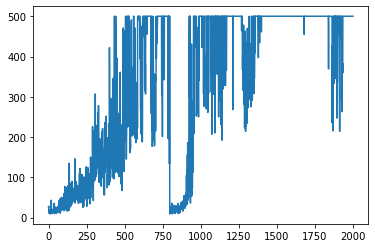

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(episode_rewards);

In [16]:
run_episode(env, policy, render=False)


(500.0,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
    